In [24]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [260]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import numpy as np
import pandas as pd
from src.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
from src.napsu_mq import marginal_query
from src.napsu_mq.markov_network_jax import MarkovNetworkJax
from src.napsu_mq.dataframe_data import DataFrameData
from src.napsu_mq import privacy_accounting
from src.napsu_mq import maximum_entropy_inference as mei
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [136]:
np.random.seed(6)
rng = jax.random.PRNGKey(42)
data_rng, suff_stat_rng, noise_rng, laplace_rng, modeling_rng = jax.random.split(rng, 5)

In [144]:
d = 3
n = 10000
generator = BinaryLogisticRegressionDataGenerator(jnp.array([1, 2]))
data = generator.generate_data(n=n, rng_key=data_rng)
dataframe = pd.DataFrame(data, columns=['A', 'B', 'C'], dtype="category")
dataframe_data = DataFrameData(dataframe)
values_by_feature = {i: [0, 1] for i in range(d)}

In [145]:
dataframe.head(n=10)

A  B  C
0  0  0  1
1  0  0  1
2  0  1  1
3  0  0  0
4  0  0  1
5  1  1  1
6  0  1  1
7  0  0  1
8  0  1  1
9  0  1  1

In [146]:
query_set = [(0, 2), (1, 2)]
fmqs = marginal_query.FullMarginalQuerySet(query_set, values_by_feature)
queries = fmqs.get_canonical_queries()

Calculating canonical queries, clique_set length: 6


  0%|                                                                                                                                                                  | 0/6 [00:00<?, ?it/s]
2it [00:00, 5903.31it/s]

4it [00:00, 7692.44it/s]

2it [00:00, 11554.56it/s]

4it [00:00, 17641.66it/s]

2it [00:00, 8371.86it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 33420.75it/s]


Calculating new queries, not_original_clique_queries length: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 6195.43it/s]


In [147]:
mnjax = MarkovNetworkJax(generator.values_by_feature, queries)

In [248]:
def model(dp_suff_stat, n, sigma_DP, prior_sigma, L_guess, mean_guess, med):
    d = med.suff_stat_d
    lambda_d = med.lambda_d
    
    prior_cov_inner = jnp.linalg.solve(L_guess, jnp.eye(lambda_d) * prior_sigma ** 2)
    norm_prior_cov = jnp.linalg.solve(L_guess, prior_cov_inner.transpose()).transpose()

    norm_prior_mu = jnp.linalg.solve(L_guess, -mean_guess.reshape((-1, 1))).flatten()

    norm_lambdas = numpyro.sample("norm_lambdas",
                                  dist.MultivariateNormal(norm_prior_mu, covariance_matrix=norm_prior_cov))
    lambdas = L_guess @ norm_lambdas + mean_guess
    mean, cov = med.suff_stat_mean_and_cov(lambdas)
    return numpyro.sample("a_hat",
                          dist.MultivariateNormal(n * mean, covariance_matrix=n * cov + jnp.eye(d) * sigma_DP ** 2),
                          obs=dp_suff_stat) 

In [281]:
%%capture
def train_model(queries, sigma_DP, mnjax):
    suff_stat = np.sum(queries.flatten()(dataframe_data.int_array), axis=0)
    dp_noise = jax.random.normal(noise_rng, suff_stat.shape) * sigma_DP
    dp_suff_stat = suff_stat + dp_noise
    
    laplace_approx, success = mei.laplace_approximation_with_jaxopt(laplace_rng, dp_suff_stat, n, sigma_DP, mnjax);
    print(success)
    
    prior_sigma = 10
    mean_guess = laplace_approx.mean
    L_guess = jnp.linalg.cholesky(laplace_approx.covariance_matrix)

    kernel = NUTS(model=model, max_tree_depth=10)
    mcmc = numpyro.infer.MCMC(
        kernel, num_samples=1000, num_warmup=1000, num_chains=4
    )

    start = time.time()
    
    mcmc.run(modeling_rng, dp_suff_stat, n, sigma_DP, prior_sigma, L_guess, mean_guess, mnjax)

    end = time.time()
    print(f"Elapsed time: {end - start}")
    
    return mcmc

Started Jaxopt Laplace approximation
Attempting Laplace approximation, 0th try
Took: 2.0847761720069684 seconds to initialise model
Initialising model done
Minimising potential function
Calculating Hessian


/tmp/ipykernel_16651/4119342596.py:14: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


True


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1256.64it/s, 15 steps of size 1.82e-01. acc. prob=0.83]


Elapsed time: 13.082716464996338


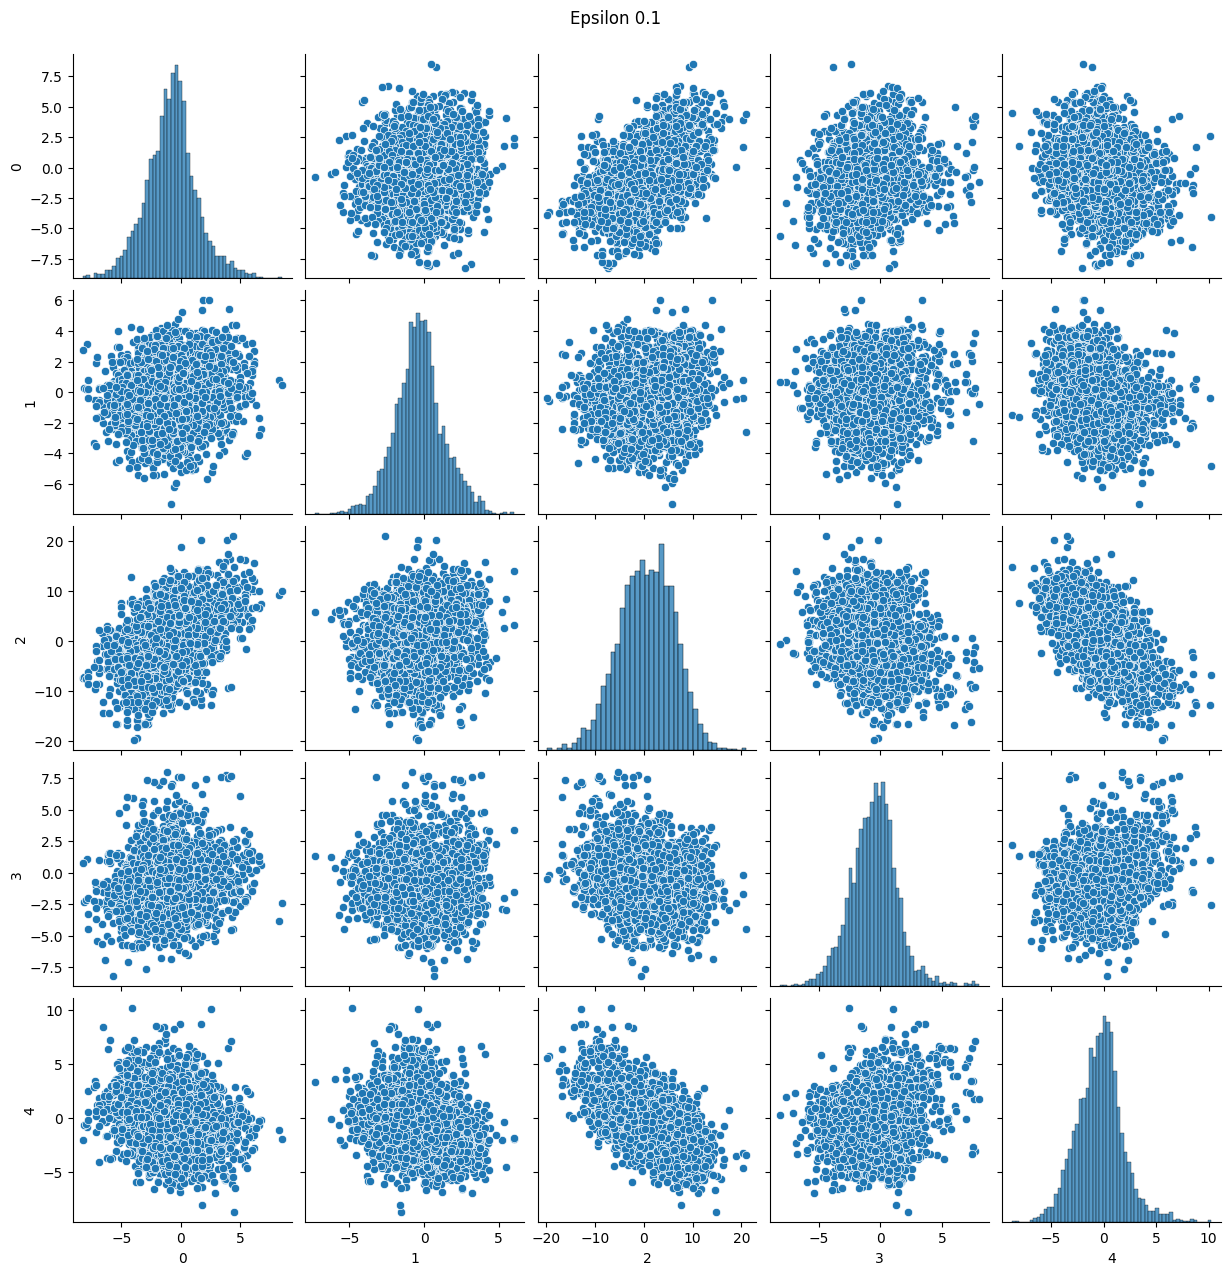

Started Jaxopt Laplace approximation
Attempting Laplace approximation, 0th try
Took: 2.532953335001366 seconds to initialise model
Initialising model done
Minimising potential function
Calculating Hessian


/tmp/ipykernel_16651/4119342596.py:14: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


True


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1036.33it/s, 31 steps of size 7.90e-02. acc. prob=0.89]


Elapsed time: 15.279390335083008


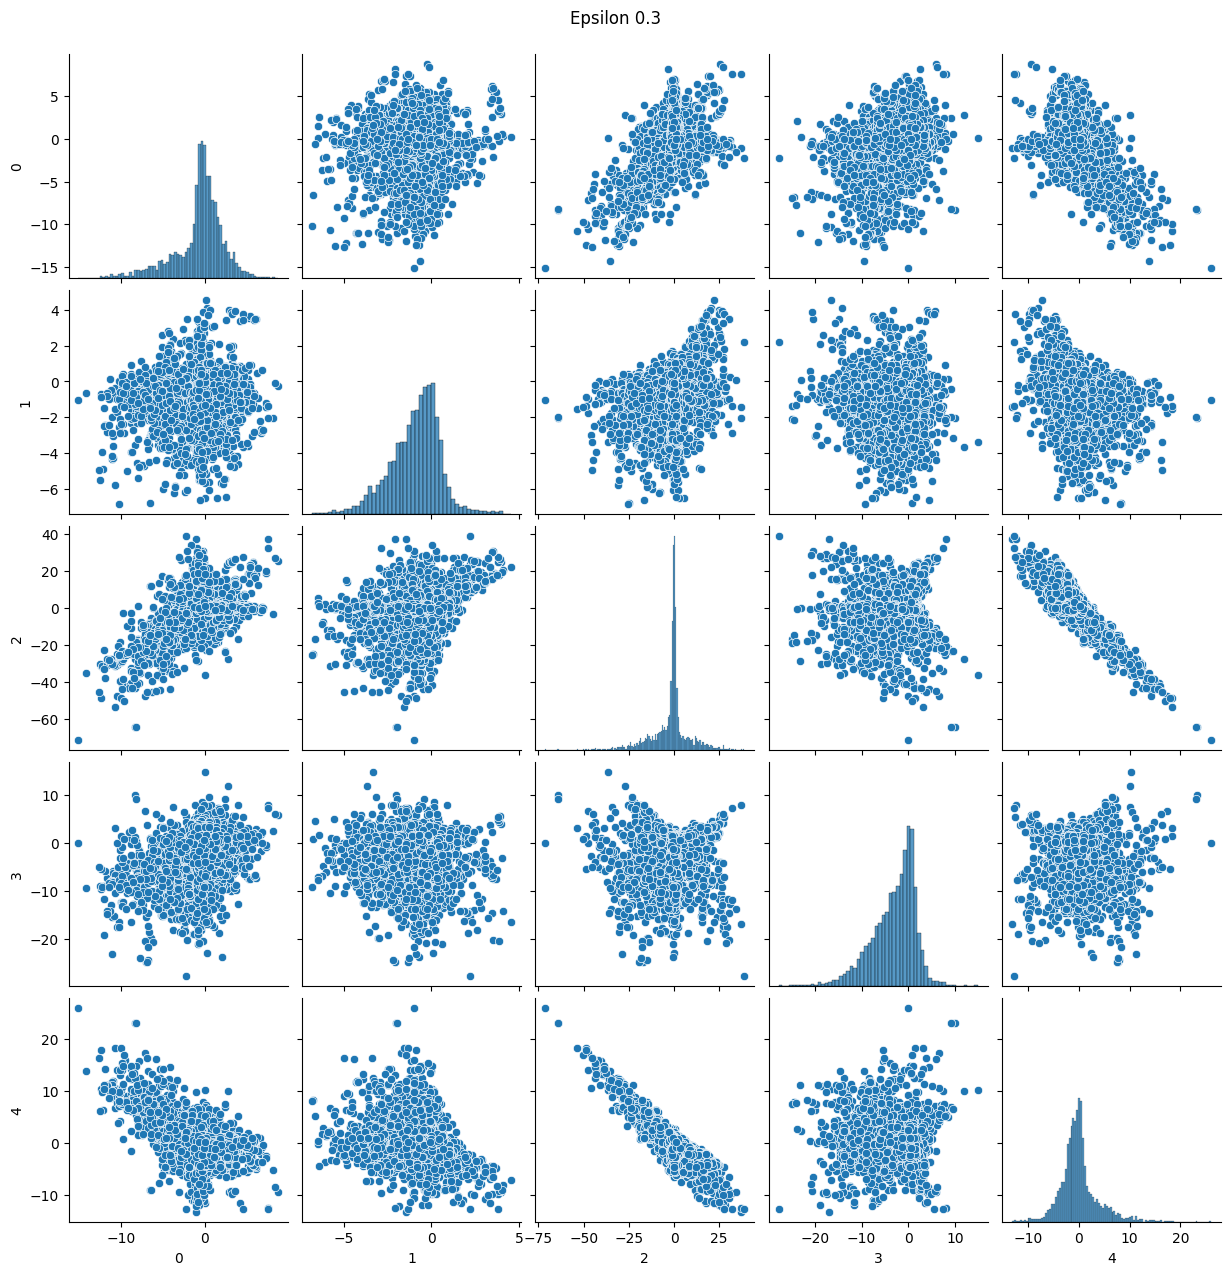

Started Jaxopt Laplace approximation
Attempting Laplace approximation, 0th try
Took: 2.8679303449971485 seconds to initialise model
Initialising model done
Minimising potential function
Calculating Hessian


/tmp/ipykernel_16651/4119342596.py:14: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


True


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1085.74it/s, 15 steps of size 1.28e-01. acc. prob=0.90]


Elapsed time: 15.688406944274902


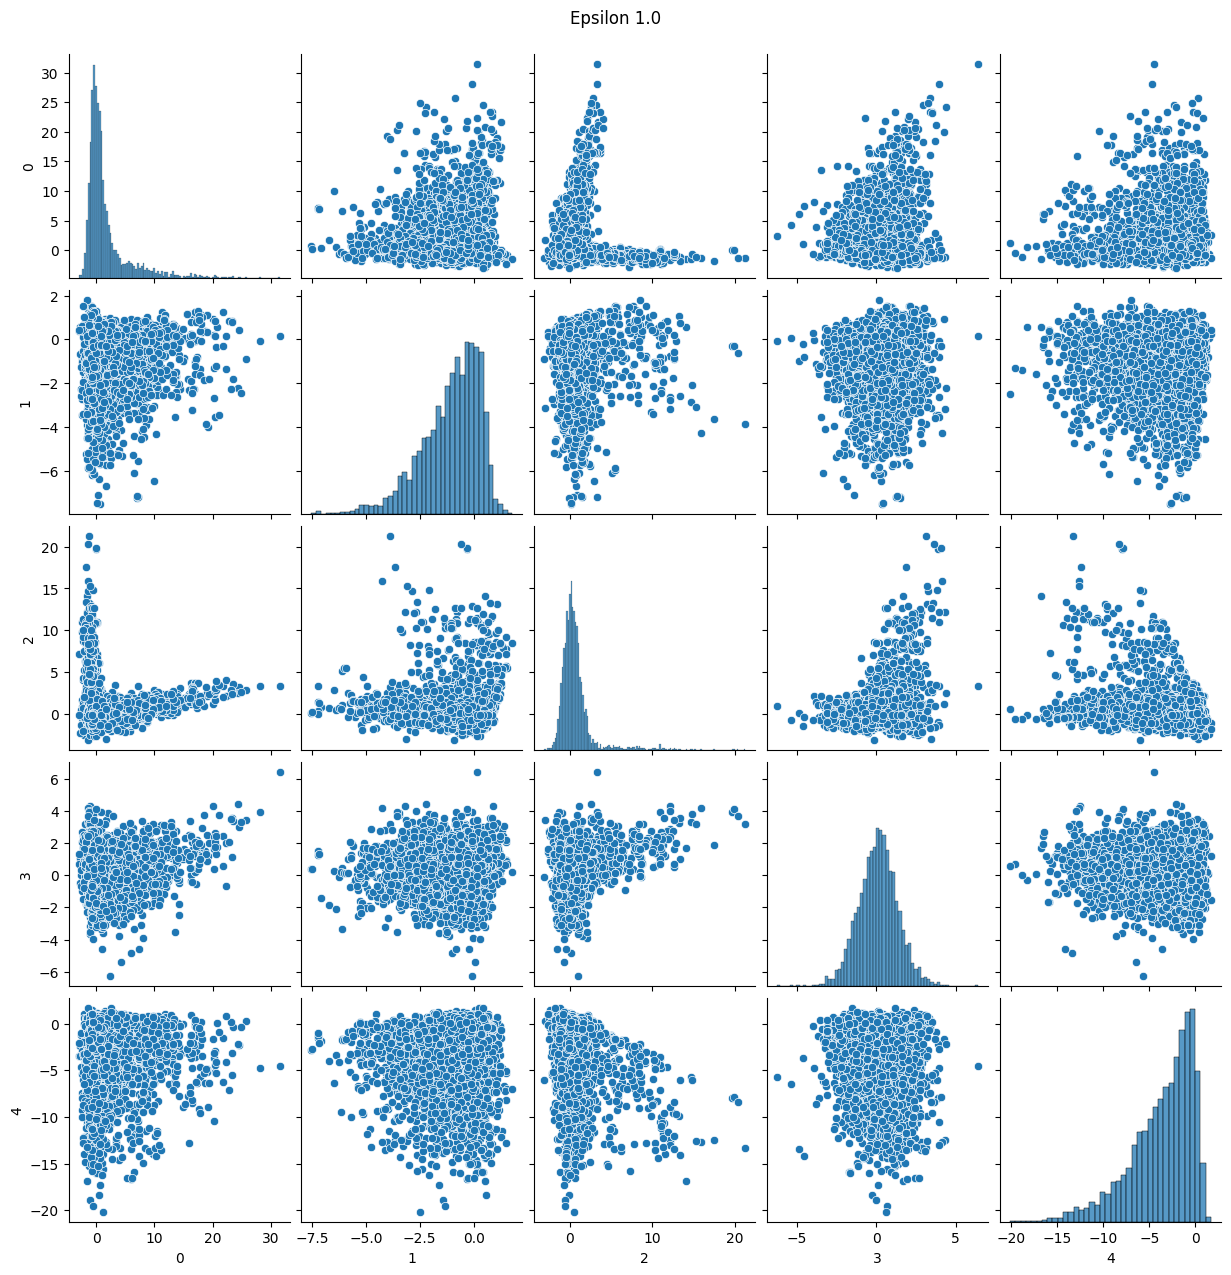

Started Jaxopt Laplace approximation
Attempting Laplace approximation, 0th try
Took: 2.7780857699981425 seconds to initialise model
Initialising model done
Minimising potential function
Calculating Hessian


/tmp/ipykernel_16651/4119342596.py:14: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


True


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1240.71it/s, 31 steps of size 1.60e-01. acc. prob=0.73]


Elapsed time: 14.84088683128357


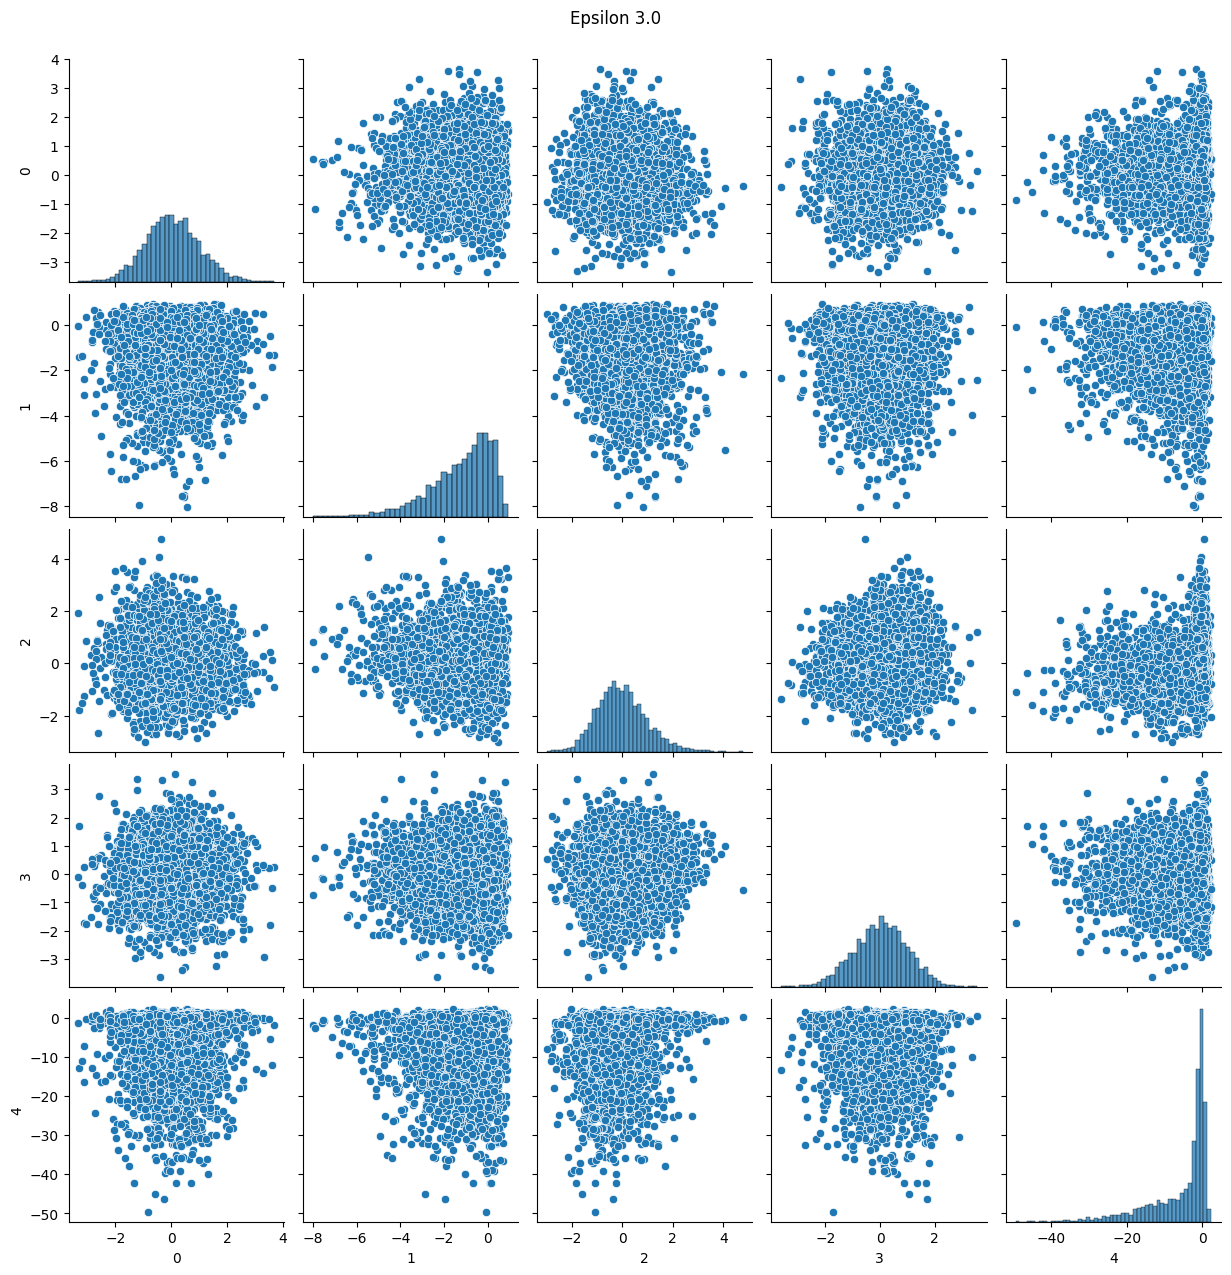

Started Jaxopt Laplace approximation
Attempting Laplace approximation, 0th try
Took: 4.594862434001698 seconds to initialise model
Initialising model done
Minimising potential function
Calculating Hessian


/tmp/ipykernel_16651/4119342596.py:14: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


True


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1203.68it/s, 15 steps of size 3.33e-01. acc. prob=0.87]


Elapsed time: 13.912771701812744


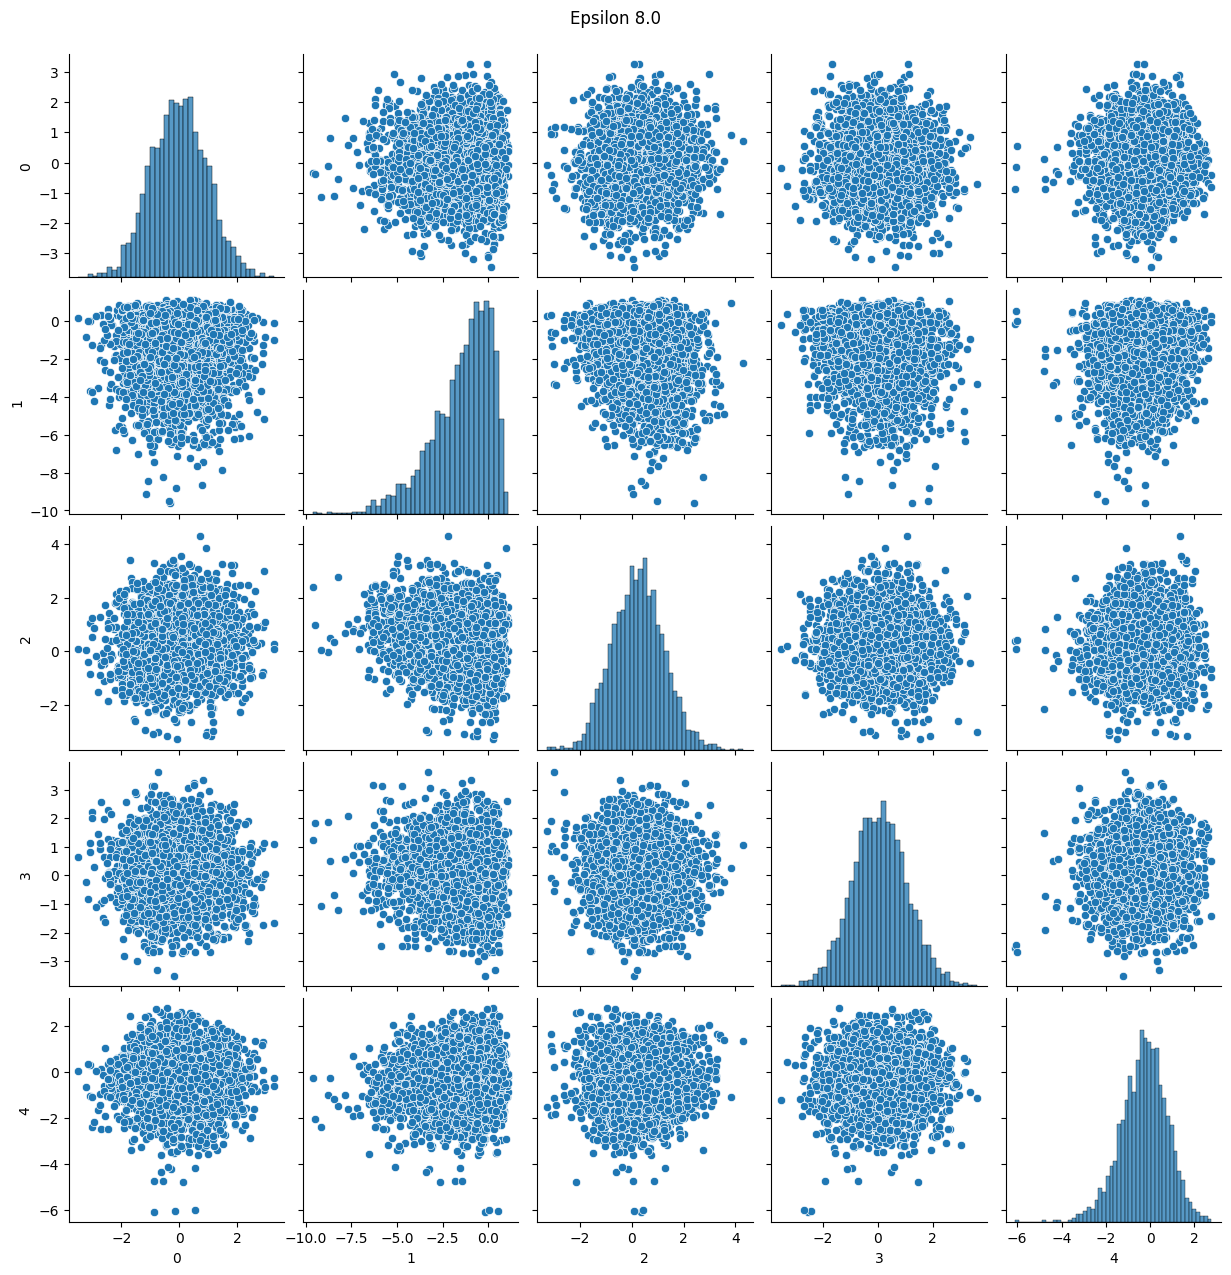

Started Jaxopt Laplace approximation
Attempting Laplace approximation, 0th try
Took: 3.1244588519984973 seconds to initialise model
Initialising model done
Minimising potential function
Calculating Hessian


/tmp/ipykernel_16651/4119342596.py:14: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


True


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1308.95it/s, 7 steps of size 5.10e-01. acc. prob=0.90]


Elapsed time: 12.83755898475647


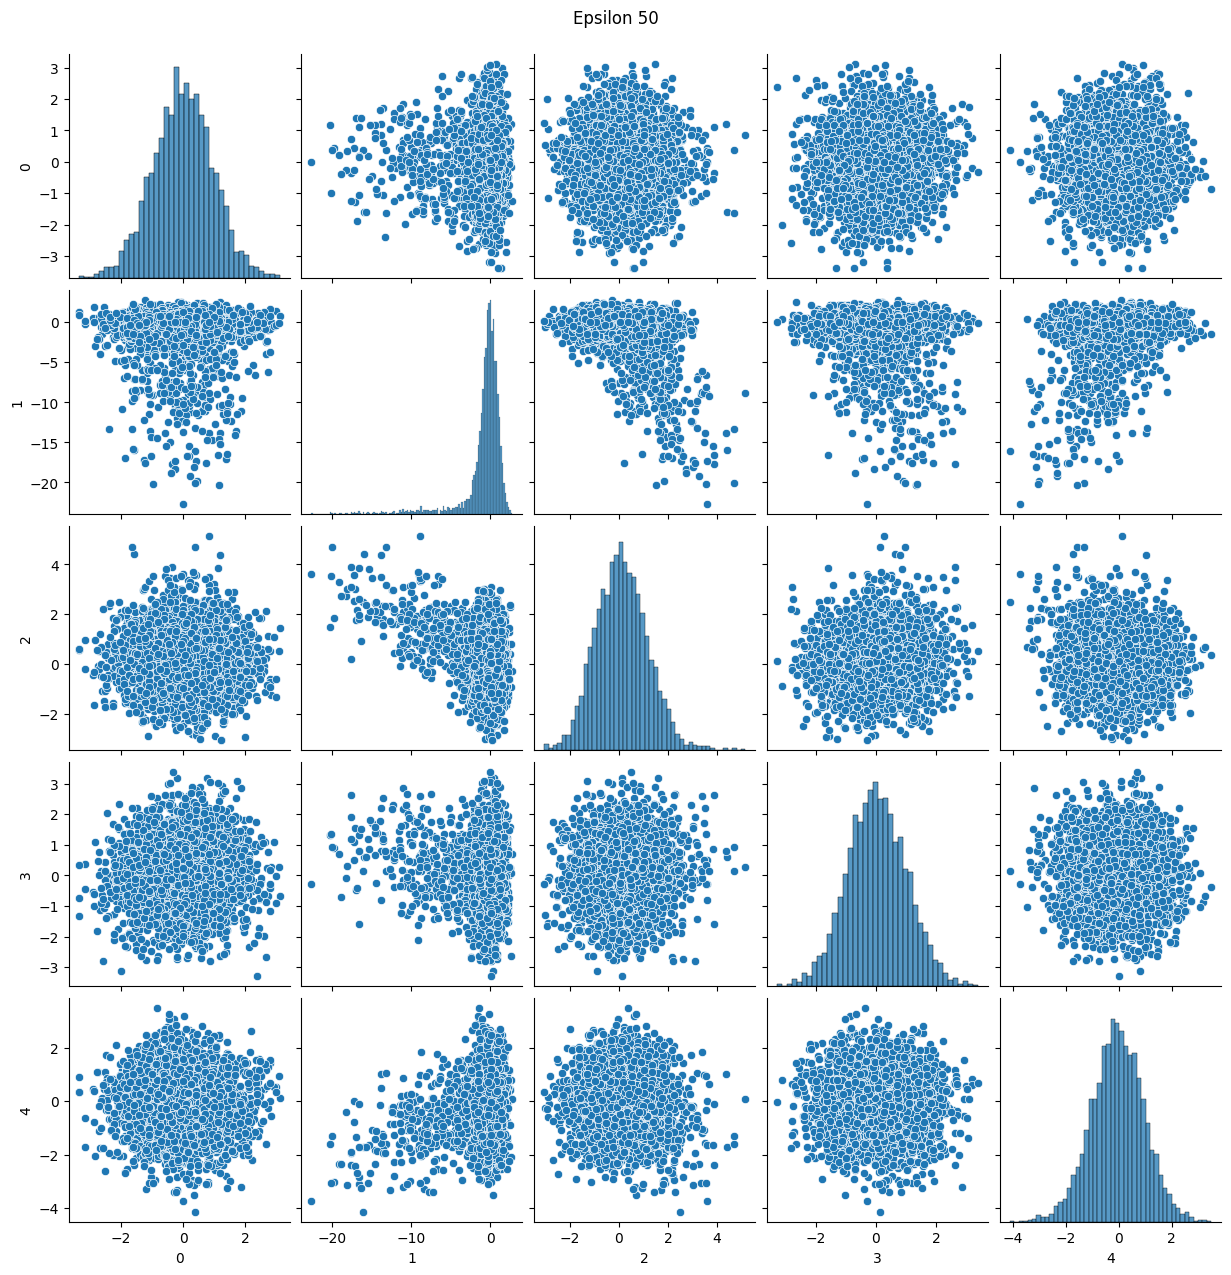

In [282]:
epsilons = [0.1, 0.3, 1.0, 3.0, 8.0, 50]

for epsilon in epsilons:
    delta = n**(-2)
    sensitivity = np.sqrt(2 * len(query_set))
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)

    mnjax = MarkovNetworkJax(generator.values_by_feature, queries)

    mcmc = train_model(queries, sigma_DP, mnjax);
    inf_data = az.from_numpyro(mcmc, log_likelihood=False)
    posterior_values = inf_data.posterior.stack(draws=("chain", "draw"))

    thinned_posterior = az.extract_dataset(inf_data, var_names=['norm_lambdas'])
    thinned_posterior_np = thinned_posterior['norm_lambdas']
    posterior_dataframe = thinned_posterior_np.to_dataframe(name="posterior").unstack(level='norm_lambdas_dim_0')
    flattened_dataframe = posterior_dataframe.droplevel(['chain'], axis=0)
    flattened_dataframe = flattened_dataframe.reset_index(drop=True)
    posterior_dataframe = flattened_dataframe['posterior']
    
    g = sns.pairplot(posterior_dataframe)
    g.fig.suptitle(f"Epsilon {epsilon}", y=1.02)
    plt.show()